In [1]:
import numpy as np
import cv2
import os
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten , Conv2D, MaxPool2D
import matplotlib.pyplot as plt

# Show sample data of 2 cattle

(<Axes: >, <matplotlib.image.AxesImage at 0x2999a1d50>)

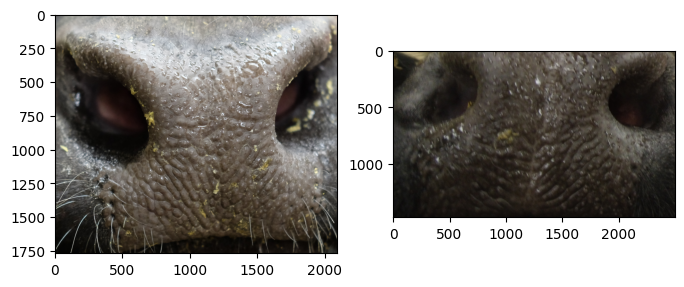

In [2]:
img1 = cv2.imread('./tests/cattle/train/cattle_0100/cattle_0100_DSCF3856.jpg')
img1 = cv2.cvtColor(img1 , cv2.COLOR_BGR2RGB)

img2 = cv2.imread('./tests/cattle/train/cattle_0200/cattle_0200_DJI_0115.jpg')
img2 = cv2.cvtColor(img2 , cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8,4))
plt.subplot(121),plt.imshow(img1)
plt.subplot(122),plt.imshow(img2)

# Set path of test and train and set image width and numbers of classes

In [3]:
width = 128
num_classes = 2
train_path = './tests/cattle/train/'
test_path = './tests/cattle/test/'
train_img = [train_path+f for f in listdir(train_path)]
test_img = [test_path+f for f in listdir(test_path)]

In [4]:
train_img, test_img

(['./tests/cattle/train/cattle_0200', './tests/cattle/train/cattle_0100'],
 ['./tests/cattle/test/cattle_0200', './tests/cattle/test/cattle_0100'])

# Create function for convert image file to rgb array

In [5]:
def img2data(path):
    rawImgs = []
    labels = []

    for imagePath in (path):
        # Not allow for .DS_Store
        # Skip .DS_Store files
        if imagePath.endswith('.DS_Store'):
            continue
      
        for item in tqdm(listdir(imagePath)):
            file = join(imagePath, item)
            if file[-1] =='g':
                img = cv2.imread(file , cv2.COLOR_BGR2RGB)
                img = cv2.resize(img ,(width,width))
                rawImgs.append(img)
          
                l = imagePath.split('/').pop()
            
                if l == 'cattle_0100':
                    labels.append([1,0])         
                elif l == 'cattle_0200':
                    labels.append([0,1])
          
          

    return rawImgs, labels

In [6]:
x_train, y_train = img2data(train_img)
x_test, y_test = img2data(test_img)

100%|██████████| 2/2 [00:00<00:00, 26.67it/s]


# Put rgb to numpy

In [7]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [8]:
x_train.shape,y_train.shape,x_test.shape, y_test.shape

((14, 128, 128, 3), (14, 2), (4, 128, 128, 3), (4, 2))

# Create model and send convolution layers

In [9]:
model0 = Sequential([
    Conv2D(128, (3,3), activation='relu', input_shape=(width, width, 3)),
    MaxPool2D(2),
    Conv2D(128,(3,3) , activation='relu'),
    MaxPool2D(pool_size=(2,2 )),
    Dense(16),
    Flatten(),
    Dense(num_classes, activation='softmax') #softmax for one hot . . # sigmoid for 0/1
])

/Users/thebusted/anaconda3/envs/aiml/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
model0.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30, 30, 16)     │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │        28,802 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 182,034 (711.07 KB)

 Trainable params: 182,034 (711.07 KB)

 Non-trainable params: 0 (0.00 B)

# Compile and train 100 epochs

In [11]:
model0.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss='categorical_crossentropy', 
    metrics= ['accuracy'])

In [12]:
batch_size = 32
epochs = 100
history = model0.fit(x_train, y_train ,batch_size=batch_size, epochs=epochs ,validation_data=(x_test, y_test))

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.4286 - loss: 0.6881 - val_accuracy: 0.5000 - val_loss: 0.6639
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step - accuracy: 0.9286 - loss: 0.5738 - val_accuracy: 0.5000 - val_loss: 0.7409
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step - accuracy: 0.4286 - loss: 0.5926 - val_accuracy: 0.5000 - val_loss: 0.7562
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step - accuracy: 0.8571 - loss: 0.4153 - val_accuracy: 0.5000 - val_loss: 0.5563
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step - accuracy: 1.0000 - loss: 0.2728 - val_accuracy: 0.5000 - val_loss: 0.5056
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step - accuracy: 0.7857 - loss: 0.3506 - val_accuracy: 0.5000 - val_loss: 1.0359
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step - accuracy: 0.9286 - loss: 0.2202 - val_accuracy: 0.5000 - val_loss: 0.9965
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step - accuracy: 1.0000 - loss: 0.1315 - val_accuracy: 1.0000 - val_

# Plot graph of accuracy and loss

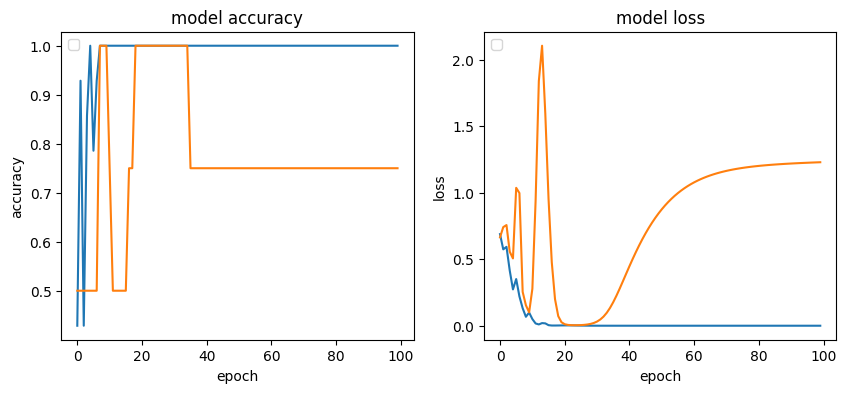

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(121),
plt.title('model accuracy');plt.ylabel('accuracy');plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.plot(history.history['accuracy']);plt.plot(history.history['val_accuracy'])

plt.subplot(122)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.plot(history.history['loss']);plt.plot(history.history['val_loss'])

# Testing model

In [14]:
testImg = [test_path+f for f in listdir(test_path)]
for imagePath in (testImg):
    if imagePath.endswith('.DS_Store'):
        continue
    for i,item in enumerate(listdir(imagePath)):
        file = join(imagePath, item)
        print(file)

./tests/cattle/test/cattle_0200/cattle_0200_DSCF3873.jpg
./tests/cattle/test/cattle_0200/cattle_0200_DSCF3871.jpg
./tests/cattle/test/cattle_0100/cattle_0100_DSCF3866.jpg
./tests/cattle/test/cattle_0100/cattle_0100_DSCF3865.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
[[6.189179e-17 1.000000e+00]]
real:cattle_0200_DSCF3873.jpg
predict:cattle_0200
-------------------
./tests/cattle/test/cattle_0200/cattle_0200_DSCF3873.jpg


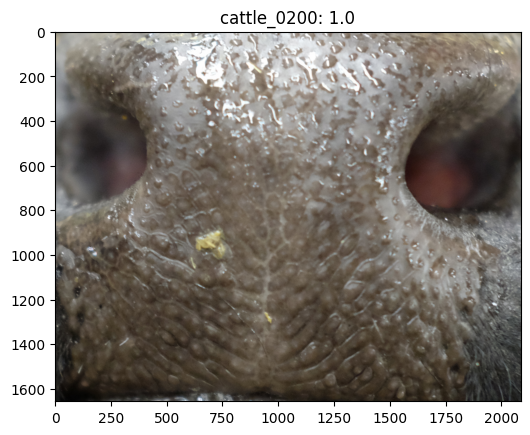

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[2.359208e-15 1.000000e+00]]
real:cattle_0200_DSCF3871.jpg
predict:cattle_0200
-------------------
./tests/cattle/test/cattle_0200/cattle_0200_DSCF3871.jpg


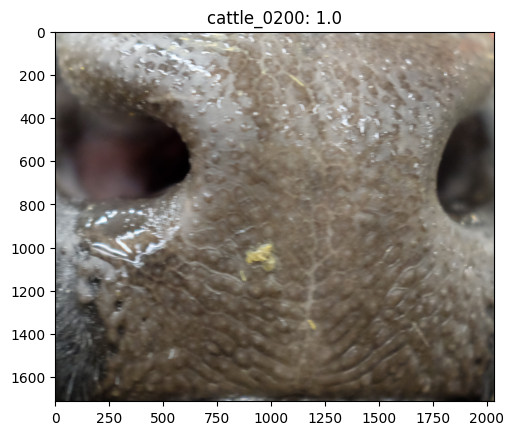

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
[[0.0085431 0.9914569]]
real:cattle_0100_DSCF3866.jpg
predict:cattle_0200
-------------------
./tests/cattle/test/cattle_0100/cattle_0100_DSCF3866.jpg


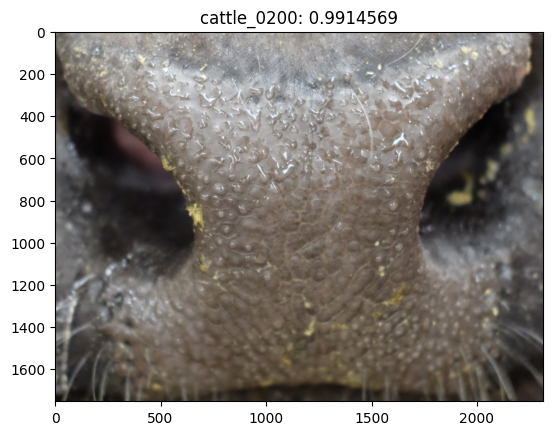

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[[0.8603823 0.1396177]]
real:cattle_0100_DSCF3865.jpg
predict:cattle_0100
-------------------
./tests/cattle/test/cattle_0100/cattle_0100_DSCF3865.jpg


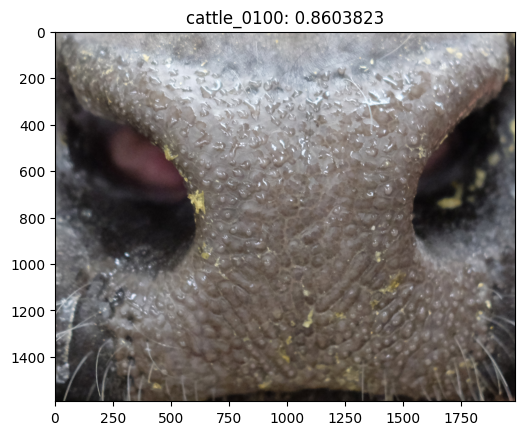

In [15]:
testImg = [test_path+f for f in listdir(test_path)]
rimg = []
for imagePath in (testImg):
    if imagePath.endswith('.DS_Store'):
        continue
    for i,item in enumerate(listdir(imagePath)):
        file = join(imagePath, item)
        if file[-1] =='g':
            img = cv2.imread(file , cv2.COLOR_BGR2RGB)
            ori = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img ,(width,width))
            rimg = np.array(img)
            rimg = rimg.astype('float32')
            rimg /= 255
            rimg = np.reshape(rimg ,(1,128,128,3))
            predict = model0.predict(rimg)
            
            # Print predict result
            probability = np.max(predict)
            
            # Hot encode to label
            hot_encode = np.argmax(predict)
            
            label = ['cattle_0100','cattle_0200']
            result = label[hot_encode]
            print(predict)
            print('real:'+str(item))
            print('predict:'+str(result))
            print('-------------------')
            
            # Print path
            print(file)
            
            # Print predict result on image
            plt.title(str(result) + ': ' + str(probability))
            
            
            plt.imshow(ori)
            plt.show()

# Conclusion

on testing above 4, result is correct 3 and wrong 1

cattle 0100 model predict as cattle 0200

# Save model to keras file

In [16]:
model0.save("model.keras")

# Create new model using tranform learning from MobileNetV3Large

In [17]:
base_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(128,128,3),
    include_top=False,
    weights='imagenet')
base_model.trainable = False
num_classes = 2

model = Sequential([
    base_model,
    Conv2D(128, 3, activation='relu'),
    Dense(16),
    Flatten(),
    Dense(num_classes, activation='softmax')
])


/Users/thebusted/anaconda3/envs/aiml/lib/python3.11/site-packages/keras/src/applications/mobilenet_v3.py:512: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


In [18]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobilenetV3large (Functional)   │ ?                      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,996,352 (11.43 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,996,352 (11.43 MB)

# Compile and train 200 epochs

In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss='categorical_crossentropy', 
    metrics= ['accuracy'])

In [20]:
batch_size = 32
epochs = 200
history = model.fit(x_train, y_train ,batch_size=batch_size, epochs=epochs ,validation_data=(x_test, y_test))

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 132s 132s/step - accuracy: 0.5714 - loss: 0.7110 - val_accuracy: 0.5000 - val_loss: 3.6998
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step - accuracy: 0.4286 - loss: 4.2630 - val_accuracy: 0.5000 - val_loss: 1.0062
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.4286 - loss: 1.1396 - val_accuracy: 0.5000 - val_loss: 1.9779
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.5714 - loss: 1.6477 - val_accuracy: 0.5000 - val_loss: 2.4516
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.5714 - loss: 2.0503 - val_accuracy: 0.5000 - val_loss: 2.0903
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.5714 - loss: 1.7386 - val_accuracy: 0.5000 - val_loss: 1.3858
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.5714 - loss: 1.1382 - val_accuracy: 0.5000 - val_loss: 0.7805
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.5714 - loss: 0.6602 - val_accuracy: 0.5000 - 

# Plot graph of accuracy and loss

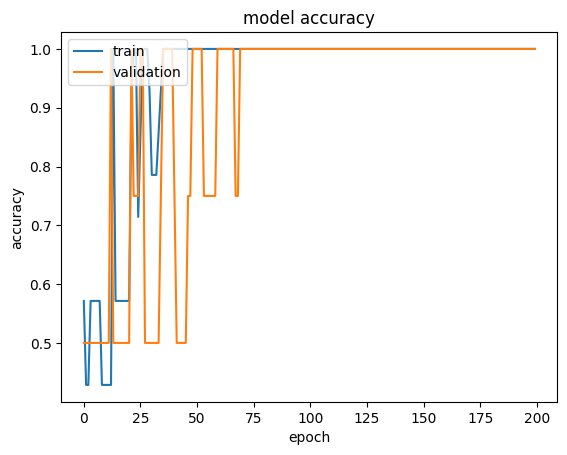

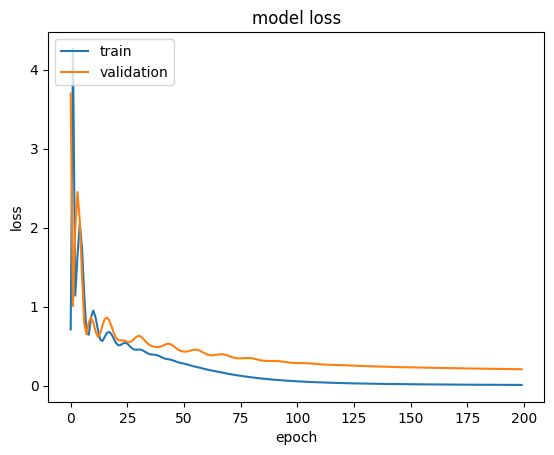

In [21]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Testing again with upgraded model

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[0.04619027 0.95380974]]
real:cattle_0200_DSCF3873.jpg
predict:cattle_0200
-------------------
./tests/cattle/test/cattle_0200/cattle_0200_DSCF3873.jpg


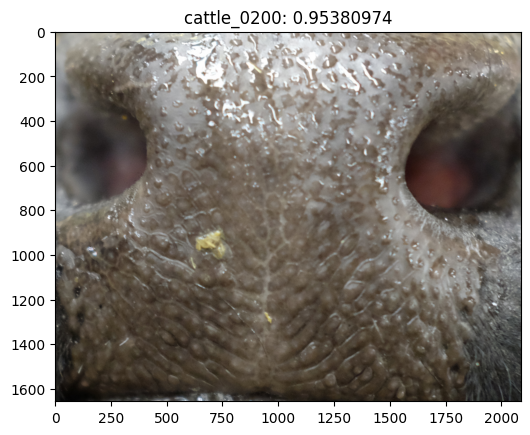

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[0.00371962 0.9962804 ]]
real:cattle_0200_DSCF3871.jpg
predict:cattle_0200
-------------------
./tests/cattle/test/cattle_0200/cattle_0200_DSCF3871.jpg


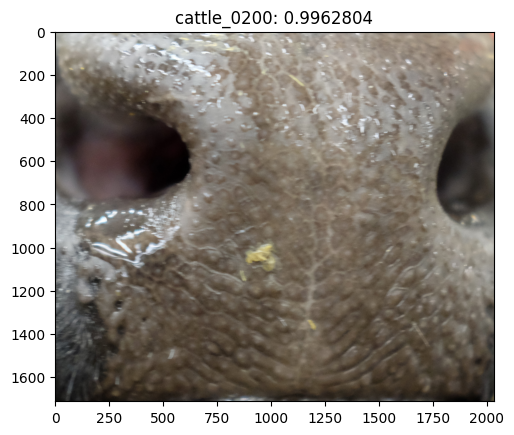

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[[0.7320219 0.2679781]]
real:cattle_0100_DSCF3866.jpg
predict:cattle_0100
-------------------
./tests/cattle/test/cattle_0100/cattle_0100_DSCF3866.jpg


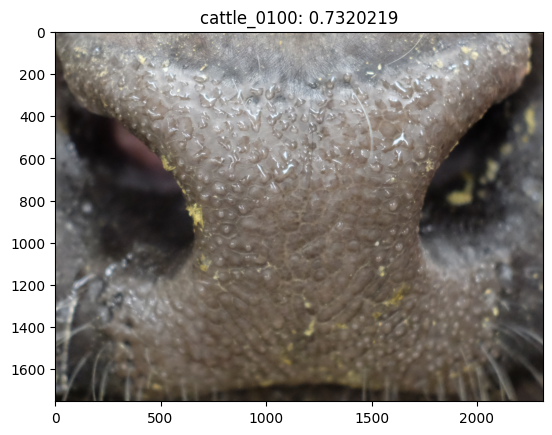

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[0.6273145 0.3726854]]
real:cattle_0100_DSCF3865.jpg
predict:cattle_0100
-------------------
./tests/cattle/test/cattle_0100/cattle_0100_DSCF3865.jpg


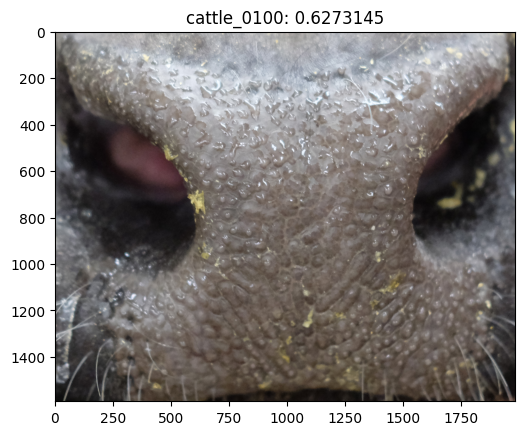

In [22]:
testImg = [test_path+f for f in listdir(test_path) if listdir(join(test_path, f))]
rimg = []
for imagePath in (testImg):
    if imagePath.endswith('.DS_Store'):
        continue
    for item in (os.listdir(imagePath)):
        file = os.path.join(imagePath, item)
        if item.split('.')[0] != "":
            img = cv2.imread(file , cv2.COLOR_BGR2RGB)
            ori = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img ,(width,width))
            rimg = np.array(img)
            rimg = rimg.astype('float32')
            rimg /= 255
            rimg = np.reshape(rimg ,(1,128,128,3))
            predict = model.predict(rimg)
            
            # Print predict result
            probability = np.max(predict)
            
            # Hot encode to label
            hot_encode = np.argmax(predict)
            
            label = ['cattle_0100','cattle_0200']
            result = label[hot_encode]
            print(predict)
            print('real:'+str(item))
            print('predict:'+str(result))
            print('-------------------')
            
            # Print path
            print(file)
            
            # Print predict result on image
            plt.title(str(result) + ': ' + str(probability))
            
            
            plt.imshow(ori)
            plt.show()

# Conclusion

from above when upgrade model using MobileNetV3Large as based model

the result is 100% correct and 3rd image is correct predicted as cattle 0100

In [23]:
model.save("model_x_mobilenetv3large.keras")

# Load saved model and testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[[0.04619027 0.95380974]]
real:cattle_0200_DSCF3873.jpg
predict:cattle_0200
-------------------
./tests/cattle/test/cattle_0200/cattle_0200_DSCF3873.jpg


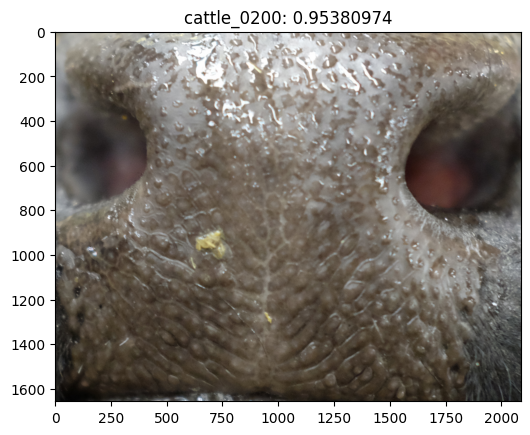

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
[[0.00371962 0.9962804 ]]
real:cattle_0200_DSCF3871.jpg
predict:cattle_0200
-------------------
./tests/cattle/test/cattle_0200/cattle_0200_DSCF3871.jpg


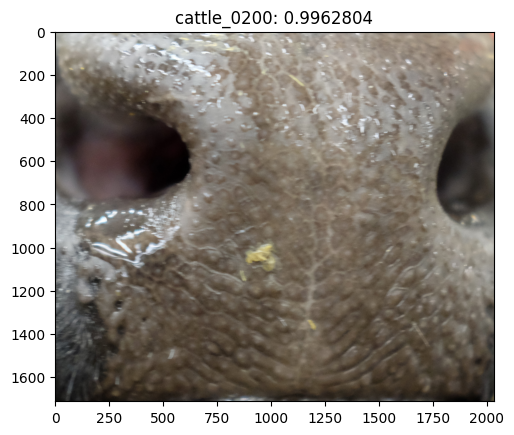

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[[0.7320219 0.2679781]]
real:cattle_0100_DSCF3866.jpg
predict:cattle_0100
-------------------
./tests/cattle/test/cattle_0100/cattle_0100_DSCF3866.jpg


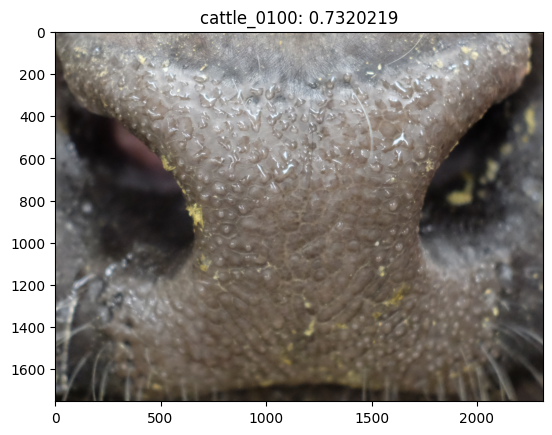

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[[0.6273145 0.3726854]]
real:cattle_0100_DSCF3865.jpg
predict:cattle_0100
-------------------
./tests/cattle/test/cattle_0100/cattle_0100_DSCF3865.jpg


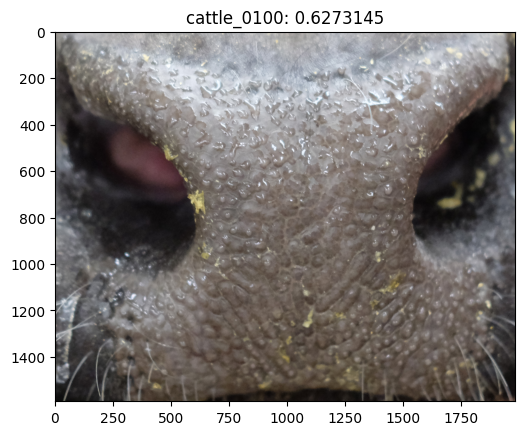

In [24]:
# Load model from file model_x_mobilenet.keras
model_x = tf.keras.models.load_model("model_x_mobilenetv3large.keras")

# Test image path
testImg = [test_path+f for f in listdir(test_path) if listdir(join(test_path, f))]
rimg = []
for imagePath in (testImg):
    if imagePath.endswith('.DS_Store'):
        continue
    for item in (os.listdir(imagePath)):
        file = os.path.join(imagePath, item)
        if item.split('.')[0] != "":
            img = cv2.imread(file , cv2.COLOR_BGR2RGB)
            ori = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img ,(width,width))
            rimg = np.array(img)
            rimg = rimg.astype('float32')
            rimg /= 255
            rimg = np.reshape(rimg ,(1,128,128,3))
            predict = model_x.predict(rimg)
            
            # Print predict result
            probability = np.max(predict)
            
            # Hot encode to label
            hot_encode = np.argmax(predict)
            
            label = ['cattle_0100','cattle_0200']
            result = label[hot_encode]
            print(predict)
            print('real:'+str(item))
            print('predict:'+str(result))
            print('-------------------')
            
            # Print path
            print(file)
            
            # Print predict result on image
            plt.title(str(result) + ': ' + str(probability))
            
            
            plt.imshow(ori)
            plt.show()